In [ ]:
import os
from datetime import datetime

import pandas as pd
import geopandas as gpd

# read data
# PATH = '../input/ieee-bigdata-cup-2022-destination-prediction/'

import os
os.chdir('/content/drive/MyDrive/final project/ieee-bigdata-cup-2022-destination-prediction/')

def get_raw_data(zone_name):
    PATH ='./train/train/'
    if os.path.exists(PATH+zone_name+'.csv'):
        df_raw_train = pd.read_csv(PATH+zone_name+'.csv', parse_dates=['Departure_time'])
        return df_raw_train
    else:
        return []

In [ ]:
label_map = {}

with open('./label_map.csv') as f:
    for line in f:
        l = line.rstrip('\n').split(',')
        if l[0] not in ['Tokyo', 'Chukyo', 'Kyushu', 'Higashisuruga', 'Kinki']:
            print(l)
            continue
        if l[1] not in  ['Occupation', 'Trip Type']:
            print(l[1])
            continue
        if not label_map.get(l[0]):
            label_map[l[0]] = {}
        if not label_map[l[0]].get(l[1]):
            label_map[l[0]][l[1]] = {}
        if len(l) == 5 and len(l[4])>0:
            label_map[l[0]][l[1]][int(l[2])] = int(l[4])

print(label_map)

['\ufeffCity', 'Type', 'Code', 'Description', 'map_label']
{'Tokyo': {'Occupation': {1: 7, 2: 8, 3: 4, 4: 5, 5: 9, 6: 6, 7: 3, 8: 2, 9: 1, 10: 12, 11: 13, 12: 14, 13: 14, 14: 15, 15: 16, 16: 21, 99: 99}, 'Trip Type': {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 46, 7: 6, 8: 6, 9: 6, 10: 7, 11: 8, 12: 9, 13: 10, 14: 11, 99: 99}}, 'Chukyo': {'Occupation': {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 99: 99}, 'Trip Type': {1: 1, 2: 2, 3: 3, 4: 12, 5: 4, 6: 4, 7: 6, 8: 2, 9: 5, 10: 5, 11: 5, 12: 46, 13: 46, 14: 1, 15: 6, 16: 6, 17: 8, 18: 7, 19: 9, 20: 10, 21: 11, 99: 99}}, 'Kyushu': {'Occupation': {1: 2, 2: 1, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 9, 9: 8, 10: 12, 11: 13, 12: 14, 13: 15, 14: 16}, 'Trip Type': {1: 1, 2: 1, 3: 2, 4: 7, 5: 8, 6: 9, 7: 12, 8: 12, 9: 11, 10: 10, 11: 10, 12: 4, 13: 5, 14: 12, 15: 6, 16: 6, 17: 2, 18: 6, 19: 3, 20: 3, 21: 3, 22: 3}}, 'Higashisuruga': {'Occupation': {1: 7, 2: 8, 3: 4, 4: 9, 5: 5, 6: 6, 7: 3, 8: 2,

In [ ]:
def maptime(departure_time):
    if departure_time.hour < 8:
        return 0
    elif departure_time.hour < 16:
        return 1
    else:
        return 2

def get_clean_data(zone_name):
    df_raw = get_raw_data(zone_name)
    if len(df_raw) == 0:
        return df_raw

    df = df_raw.dropna()
    df.drop_duplicates(inplace = True)

    df['Occupation_washed'] = df.apply(lambda x: int(x['Occupation']) if not label_map[zone_name]['Occupation'].get(x['Occupation']) else int(label_map[zone_name]['Occupation'][x['Occupation']]), axis=1)

    df['Occupation_Categorical'] = df['Occupation_washed'].map({1: 'Managers', 2: 'Technicians', \
                                 3: 'Clerical', 4: 'Sales', \
                                 5: 'Services', 6: 'Security', \
                                 7: 'Argriculture', 8: 'Laborer', \
                                 9: 'Transport', 10: 'Architecture', \
                                 11: 'Porter', 12: 'Other', \
                                 13: 'Preschoolers', 14: 'High', \
                                 15: 'Homemakers', 16: 'Inoccupation', \
                                 21: 'Employed', 99: 'Unknown'})

    df['Trip_type_washed'] = df.apply(lambda x: int(x['Trip_type']) if not label_map[zone_name]['Trip Type'].get(x['Trip_type']) else int(label_map[zone_name]['Trip Type'][x['Trip_type']]), axis=1)

    df['Trip_type_Categorical'] = df['Trip_type_washed'].map({1: 'Work', 2: 'School', \
                                 3: 'Home', 4: 'Shopping', \
                                 5: 'Entertainment', 6: 'Other', \
                                 7: 'Sales', 8: 'Meeting', \
                                 9: 'Repair', 10: 'Farm', \
                                 11: 'Business', 12: 'Back', \
                                 46: 'Free', 47: 'Business', \
                                 99: 'Unknown'})

    df['Departure_time_washed'] = df['Departure_time'].apply(maptime)
    df['Gender_Categorical'] = df['Gender'].map({1: 'Male', 2: 'Female'})
    df['Departure_time_washed_Categorical'] = df['Departure_time_washed'].map({0: 'Morning', 1: 'Noon', 2: 'Evening'})
    catcols = df.select_dtypes(['object']).columns
    df[catcols] = df[catcols].astype('category')
    return  df

In [ ]:
def get_round_trip_label(df):
    df = df.sort_values(by=['Pid', 'Departure_time'], ascending=True)
    data_len = len(df)
    # 0: not a roundtrip  1: a round trip
    round_trip =[]
    # store the last record
    cache_record = {'Pid':-1,'Departure_time':datetime(1900,1,1)}
    for i in range(data_len):
        # whether the only record
        row = df.iloc[i]
        if i+1==data_len:
            next_row = {'Pid':-1,'Departure_time':datetime(1900,1,1), 'Origin':-1, 'Destination':-1}
        else:
            next_row = df.iloc[i+1]
        if (cache_record.get('Pid') != row['Pid'] or cache_record.get('Departure_time').date() != row['Departure_time'].date()) and (i+1==data_len or ( next_row['Pid'] != df.iloc[i]['Pid'] or next_row['Departure_time'].date() != row['Departure_time'].date() ) ):
            if(row['Origin'] != row['Destination']):
                round_trip.append(0)
            else:
                round_trip.append(1)

        # mulit record
        else:
            if (i+1==data_len or ( next_row['Pid'] != row['Pid'] or next_row['Departure_time'].date() != row['Departure_time'].date() ) ):
                if (row['Destination'] != cache_record['last_Origin']):
                    round_trip.append(0)
                else:
                    round_trip.append(1)
            else:
                if(row['Destination'] != next_row['Origin']):
                    round_trip.append(0)
                else:
                    round_trip.append(1)
        # update the last record
        if  cache_record.get('Pid') != row['Pid']:
            cache_record['Pid'] = row['Pid']
            cache_record['Departure_time'] = row['Departure_time']
            cache_record['last_Origin'] = row['Origin']
            cache_record['last_Destination'] = row['Destination']
        elif cache_record.get('Departure_time').date() != row['Departure_time'].date():
            cache_record['Departure_time'] = row['Departure_time']
            cache_record['last_Origin'] = row['Origin']
            cache_record['last_Destination'] = row['Destination']
        else:
            cache_record['Departure_time'] = row['Departure_time']
            cache_record['last_Destination'] = row['Destination']
    df['round_trip'] = round_trip
    return  df

In [ ]:
def getgeoattr(df, zone_name,col_name='Origin'):
    zone_feature_path = './Zone_features/Zone_features/'
    zone_feature_dict = {}
    add_attr = ['T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']
    zone_feature_file_path = zone_feature_path+zone_name+'_zone_feature_area.csv'
    with open(zone_feature_file_path, 'r') as f:
        for line in f:
            l = line.rstrip('\n').split(',')
            if l[0][0] not in [str(i) for i in range(10)]:
                print(l)
                continue
            temp = {}
            temp['Origin'] = int(l[0])
            for i,v in enumerate(add_attr):
                temp[v] = float(l[i+1])
            zone_feature_dict[int(l[0])] = temp
    df_join = []
    for i in range(len(df)):
        r = df.iloc[i]
        temp = zone_feature_dict.get(int(r[col_name]), {'Origin':int(r[col_name]), 'T000918002':-1, 'T000918006':-1, 'T000918021':-1, 'T000918025':-1, 'T000847001':-1})
        df_join.append(temp)
    df_join = pd.DataFrame(df_join)
    for v in add_attr:
        df[v] = list(df_join[v])
    return df



In [ ]:
zone_list = ['Tokyo', 'Chukyo', 'Kyushu', 'Higashisuruga', 'Kinki']
train_data = {}
for zone_name in zone_list[:4]:
    df = get_clean_data(zone_name)
    df = get_round_trip_label(df)
    df = getgeoattr(df, zone_name)
    train_data[zone_name] = df
df = get_clean_data('Kinki')
df = getgeoattr(df, zone_name)
train_data['Kinki'] = df
len(train_data['Kinki'])

['ZONE_ID', 'T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']
['ZONE_ID', 'T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']
['ZONE_ID', 'T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']
['ZONE_ID', 'T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']
['ZONE_ID', 'T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']


967459

In [ ]:
import copy
df_all = pd.concat([train_data['Tokyo'], train_data['Chukyo'], train_data['Kyushu'],train_data['Higashisuruga']], ignore_index=True)

In [ ]:
train_data['Chukyo'].head(100)

,Pid,Departure_time,Gender,Age,Occupation,Trip_type,Origin,Destination,Occupation_washed,Occupation_Categorical,...,Trip_type_Categorical,Departure_time_washed,Gender_Categorical,Departure_time_washed_Categorical,round_trip,T000918002,T000918006,T000918021,T000918025,T000847001
170487,2,2011-10-03 13:00:00,1,10,4,17,20101,20101,4,Sales,...,Meeting,1,Male,Noon,1,28.130746,168.611317,169.922976,1325.203854,2201.242187
170488,2,2011-10-03 13:20:00,1,10,4,5,20101,20101,4,Sales,...,Shopping,1,Male,Noon,1,28.130746,168.611317,169.922976,1325.203854,2201.242187
170489,2,2011-10-03 15:00:00,1,10,4,17,20101,20101,4,Sales,...,Meeting,1,Male,Noon,1,28.130746,168.611317,169.922976,1325.203854,2201.242187
170490,2,2011-10-03 16:00:00,1,10,4,18,20101,20101,4,Sales,...,Sales,2,Male,Evening,1,28.130746,168.611317,169.922976,1325.203854,2201.242187
180101,3,2011-10-03 13:00:00,2,16,4,17,20101,20101,4,Sales,...,Meeting,1,Female,Noon,1,28.130746,168.611317,169.922976,1325.203854,2201.242187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173921,98,2011-10-03 08:30:00,2,10,3,1,20204,20202,3,Clerical,...,Work,1,Female,Noon,0,28.005091,101.854707,209.276266,1215.176671,2706.855041
173922,98,2011-10-03 18:00:00,2,10,3,5,20204,22002,3,Clerical,...,Shopping,2,Female,Evening,0,28.005091,101.854707,209.276266,1215.176671,2706.855041
181577,99,2011-10-03 07:30:00,1,7,16,7,20204,20406,16,Inoccupation,...,Other,0,Male,Morning,0,28.005091,101.854707,209.276266,1215.176671,2706.855041
181578,99,2011-10-03 11:00:00,1,7,16,16,20204,20206,16,Inoccupation,...,Other,1,Male,Noon,0,28.005091,101.854707,209.276266,1215.176671,2706.855041


In [ ]:
work = df_all[df_all['Trip_type_washed']==1]
len(work)/len(df_all)

0.29526206603987076

In [ ]:
test_df = train_data['Kinki']
test_Entertainment = test_df[test_df['Trip_type_washed'] == 5]

In [ ]:
len(test_Entertainment)/len(test_df)

0.1399191076831163

<Axes: >

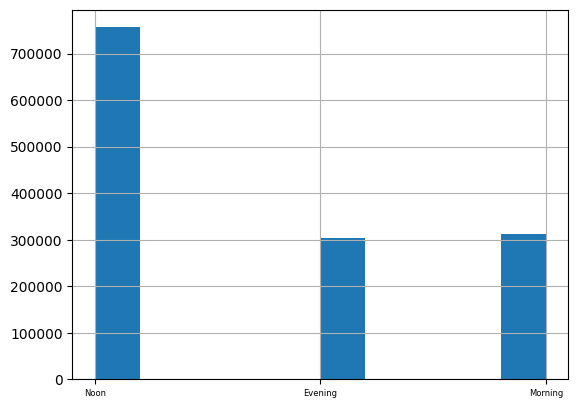

In [ ]:
df_all['Departure_time_washed_Categorical'].hist(xlabelsize=6)

<Axes: >

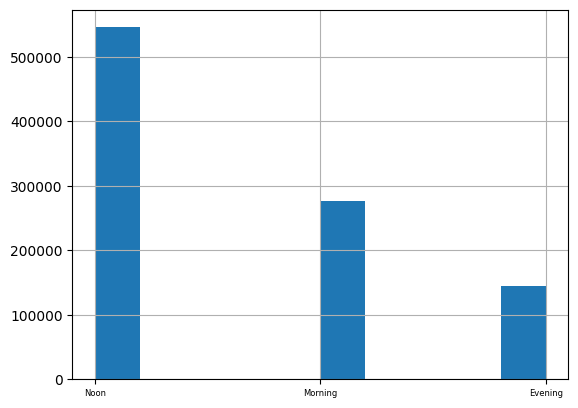

In [ ]:
train_data['Kinki']['Departure_time_washed_Categorical'].hist(xlabelsize=6)

In [ ]:
rt_data = df_all[df_all['round_trip'] == 1]
nrt_data = df_all[df_all['round_trip'] == 0]

<Axes: >

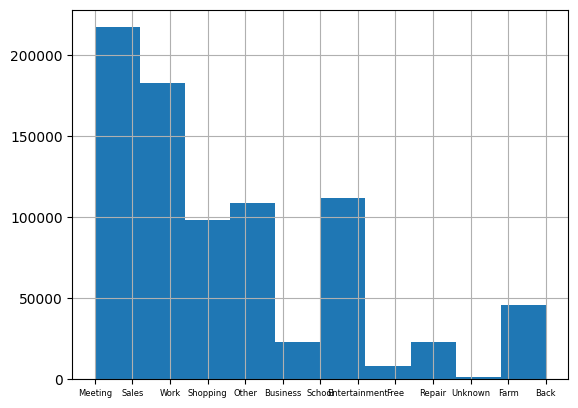

In [ ]:
rt_data['Trip_type_Categorical'].hist(xlabelsize=6)

<Axes: >

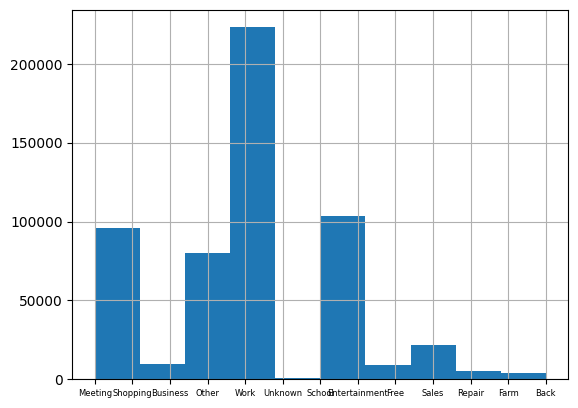

In [ ]:
nrt_data['Trip_type_Categorical'].hist(xlabelsize=6)

In [ ]:
m = { 1: 'To Work', 2: 'To School', \
    3: 'To Home', 4: 'To Shopping', \
    5: 'To Eat/Social/Entertainment', 6: 'Other Private Purpose (including To Hospital and Pickup)', \
    7: 'For Sales/Delivery/Restock/Purchase', 8: 'For Meeting/Withdraw/Doctors Visit', \
    9: 'Repair', 10: 'Farm Chores', \
    11: 'Other Business Purpose', 12: 'Back to Work/School', \
    46: 'Free Purpose', \
    99: 'Unknown'}
df = {'label':[], 'round':[], 'non':[]}
for k in m:
  df['label'].append(m[k])
  total = len(df_all[df_all['Trip_type_washed']==k])
  p = 0 if total == 0 else len(rt_data[rt_data['Trip_type_washed']==k])/total
  df['round'].append(p*100)
  p = 0 if total == 0 else  len(nrt_data[nrt_data['Trip_type_washed']==k])/total
  df['non'].append(p*100)
df = pd.DataFrame(df)
df

,label,round,non
0,To Work,45.017694,54.982306
1,To School,50.520023,49.479977
2,To Home,0.000000,0.000000
3,To Shopping,53.154147,46.845853
4,To Eat/Social/Entertainment,53.970885,46.029115
5,Other Private Purpose (including To Hospital a...,57.663472,42.336528
6,For Sales/Delivery/Restock/Purchase,88.007344,11.992656
7,For Meeting/Withdraw/Doctors Visit,85.937094,14.062906
8,Repair,81.959169,18.040831
9,Farm Chores,93.052734,6.947266


In [ ]:
m = { 1: 'Managers', 2: 'Technicians and Professionals', \
    3: 'Clerical Assistants', 4: 'Sales', \
    5: 'Services', 6: 'Security Inspectors', \
    7: 'Argriculture Forestry and Fishery', 8: 'Laborer', \
    9: 'Transport', 10: 'Architecture and Mining Workers', \
    11: 'Porter Cleaner and Packer', 12: 'Other Occupation', \
    13: 'Preschoolers Elementary and Middle School Students', 14: 'High School Students and above', \
    15: 'Homemakers', 16: 'Inoccupation', \
    21: 'Employed(Detail Unknown)', 99: 'Unknown'}
df = {'label':[], 'round':[], 'non':[]}
for k in m:
  df['label'].append(m[k])
  total = len(df_all[df_all['Occupation_washed']==k])
  p = 0 if total == 0 else len(rt_data[rt_data['Occupation_washed']==k])/total
  df['round'].append(p*100)
  p = 0 if total == 0 else  len(nrt_data[nrt_data['Occupation_washed']==k])/total
  df['non'].append(p*100)
df = pd.DataFrame(df)
df

,label,round,non
0,Managers,58.251137,41.748863
1,Technicians and Professionals,55.044208,44.955792
2,Clerical Assistants,55.278756,44.721244
3,Sales,67.738935,32.261065
4,Services,59.223923,40.776077
5,Security Inspectors,57.090086,42.909914
6,Argriculture Forestry and Fishery,72.879942,27.120058
7,Laborer,59.032731,40.967269
8,Transport,61.116023,38.883977
9,Architecture and Mining Workers,46.070812,53.929188


<Axes: >

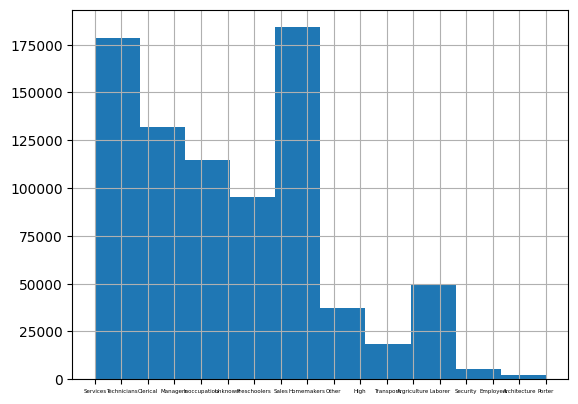

In [ ]:
rt_data['Occupation_Categorical'].hist(xlabelsize=4)

<Axes: >

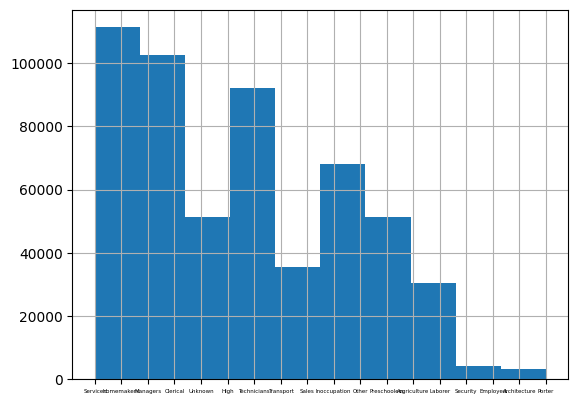

In [ ]:
nrt_data['Occupation_Categorical'].hist(xlabelsize=4)

# trip record analysis

In [ ]:
zone_feature = {}
for zone_name in zone_list:
  zone_feature_path = './Zone_features/Zone_features/'
  zone_feature_file_path = zone_feature_path+zone_name+'_zone_feature_area.csv'
  df = pd.read_csv(zone_feature_file_path)
  zone_feature[zone_name] =df
zf_all = pd.concat([zone_feature['Tokyo'], zone_feature['Chukyo'], zone_feature['Kyushu'],zone_feature['Higashisuruga'],zone_feature['Kinki']], ignore_index=True)
zf_all.corr()

,ZONE_ID,T000918002,T000918006,T000918021,T000918025,T000847001
ZONE_ID,1.000000,-0.162691,-0.085679,-0.129179,-0.095520,-0.188136
T000918002,-0.162691,1.000000,0.653958,0.705365,0.568433,0.594927
T000918006,-0.085679,0.653958,1.000000,0.713272,0.912627,0.367312
T000918021,-0.129179,0.705365,0.713272,1.000000,0.809929,0.280525
T000918025,-0.095520,0.568433,0.912627,0.809929,1.000000,0.215985
T000847001,-0.188136,0.594927,0.367312,0.280525,0.215985,1.000000


In [ ]:
len(train_data['Tokyo'])

790613

In [ ]:
len(set(list(train_data['Tokyo']['Pid'])))

470140

In [ ]:
len(train_data['Chukyo'])

205435

In [ ]:
len(set(list(train_data['Chukyo']['Pid'])))

135910

In [ ]:
len(train_data['Kyushu'])

343747

In [ ]:
len(set(list(train_data['Kyushu']['Pid'])))

147968

In [ ]:
len(train_data['Higashisuruga'])

34496

In [ ]:
len(set(list(train_data['Higashisuruga']['Pid'])))

21968

In [ ]:
df = get_clean_data('Kinki')
df = getgeoattr(df, zone_name)
train_data['Kinki'] = df
len(train_data['Kinki'])

['ZONE_ID', 'T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']


967459

In [ ]:
len(set(list(train_data['Kinki']['Pid'])))

624511

In [ ]:
train_data['Tokyo'].describe()

,Pid,Departure_time,Gender,Age,Occupation,Trip_type,Origin,Destination,Occupation_washed,Trip_type_washed,Departure_time_washed,round_trip,T000918002,T000918006,T000918021,T000918025,T000847001
count,790613.000000,790613,790613.000000,790613.000000,790613.000000,790613.000000,790613.000000,790613.000000,790613.000000,790613.000000,790613.000000,790613.000000,790613.000000,790613.000000,790613.000000,790613.000000,790613.000000
mean,286422.961516,2008-10-01 11:16:46.576719616,1.513932,8.395085,10.452158,4.663179,21159.079469,18984.366843,9.631814,4.625117,0.917526,0.499049,58.975917,503.417569,936.818308,8571.209292,9456.460051
min,1.000000,2008-10-01 03:00:00,1.000000,1.000000,1.000000,1.000000,100.000000,100.000000,1.000000,1.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,136649.000000,2008-10-01 07:55:00,1.000000,6.000000,7.000000,1.000000,6311.000000,4111.000000,3.000000,1.000000,0.000000,0.000000,18.960978,89.540498,147.759617,947.886389,4472.734023
50%,286021.000000,2008-10-01 10:00:00,2.000000,8.000000,9.000000,4.000000,13401.000000,11403.000000,8.000000,4.000000,1.000000,0.000000,37.078064,210.882598,358.600561,2201.484907,9191.986047
75%,432782.000000,2008-10-01 14:30:00,2.000000,12.000000,14.000000,7.000000,35120.000000,32151.000000,15.000000,6.000000,1.000000,1.000000,69.037878,466.858527,841.564225,4749.202358,14069.633195
max,588568.000000,2008-10-02 02:50:00,2.000000,17.000000,99.000000,99.000000,60931.000000,60931.000000,99.000000,99.000000,2.000000,1.000000,739.952140,7422.312522,24237.004405,184695.318024,31616.850418
std,170333.821778,NaN,0.499806,3.891511,10.980001,5.754973,17367.967016,17570.281323,11.776296,7.419999,0.647430,0.499999,74.764869,935.636479,2047.277386,22541.066839,6607.233187


<Axes: ylabel='Frequency'>

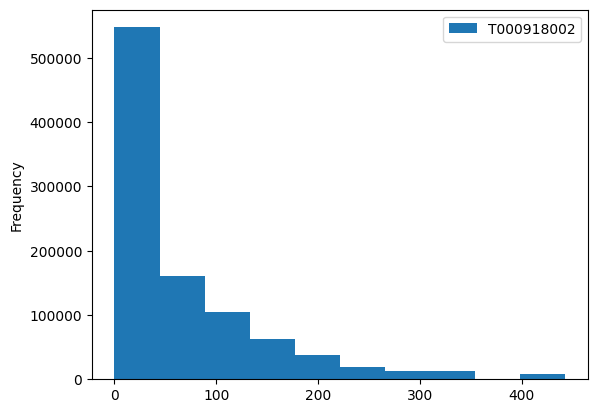

In [ ]:
train_data['Kinki'].plot(kind='hist', column='T000918002')
# train_data['Tokyo'].plot(kind='hist', column='T000918002')

In [ ]:
def get_freq_data(zone_df, zone_name, col_name='ZONE_ID'):
  d = {}
  d_o = {}
  d_d = {}
  df = get_raw_data(zone_name=zone_name)
  for i,row in df.iterrows():
    index = int(row['Origin'])
    d[index] = d.get(index, 0) + 1
    d_o[index] = d_o.get(index, 0) + 1
    if 'Destination' in row.keys():
      index = int(row['Destination'])
      d[index] = d.get(index, 0) + 1
      d_d[index] = d_d.get(index, 0) + 1
  df_join = []
  o_join = []
  d_join = []
  for i in range(len(zone_df)):
      r = zone_df.iloc[i]
      temp = d.get(int(r[col_name]), 0)
      df_join.append(temp)
      temp_o = d_o.get(int(r[col_name]), 0)
      o_join.append(temp_o)
      temp_d = d_d.get(int(r[col_name]), 0)
      d_join.append(temp_d)
  zone_df['freq'] = list(df_join)
  zone_df['origin_freq'] = list(o_join)
  zone_df['dest_freq'] = list(d_join)
  return zone_df

In [ ]:
zone_path = './Zones/Zones/'
zone_list = ['Tokyo', 'Chukyo', 'Kyushu', 'Higashisuruga', 'Kinki']
geodataframe_data = {}
for zone_name in zone_list:
    zone_pd = gpd.read_file(zone_path+zone_name+'/'+zone_name+'.shp')
    zone_pd = getgeoattr(zone_pd, zone_name,col_name='ZONE_ID')
    zone_pd = get_freq_data(zone_pd, zone_name)
    geodataframe_data[zone_name] = zone_pd


['ZONE_ID', 'T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']
['ZONE_ID', 'T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']
['ZONE_ID', 'T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']
['ZONE_ID', 'T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']
['ZONE_ID', 'T000918002', 'T000918006', 'T000918021', 'T000918025', 'T000847001']


In [ ]:
len(geodataframe_data['Tokyo'])

1655

In [ ]:
len(geodataframe_data['Chukyo'])

1009

In [ ]:
len(geodataframe_data['Kyushu'])

565

In [ ]:
len(geodataframe_data['Higashisuruga'])

78

In [ ]:
len(geodataframe_data['Kinki'])

1080

In [ ]:
geodataframe_data['Tokyo'][['origin_freq','dest_freq']].corr()

,origin_freq,dest_freq
origin_freq,1.000000,0.813921
dest_freq,0.813921,1.000000


In [ ]:
geodataframe_data['Chukyo'][['origin_freq','dest_freq']].corr()

,origin_freq,dest_freq
origin_freq,1.000000,0.743918
dest_freq,0.743918,1.000000


In [ ]:
geodataframe_data['Kyushu'][['origin_freq','dest_freq']].corr()

,origin_freq,dest_freq
origin_freq,1.000000,0.996793
dest_freq,0.996793,1.000000


In [ ]:
geodataframe_data['Higashisuruga'][['origin_freq','dest_freq']].corr()

,origin_freq,dest_freq
origin_freq,1.000000,0.908387
dest_freq,0.908387,1.000000


<Axes: >

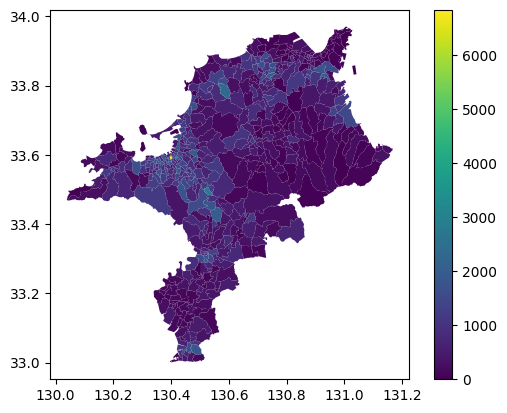

In [ ]:
geodataframe_data['Kyushu'].plot(column='origin_freq',legend=True)

<Axes: >

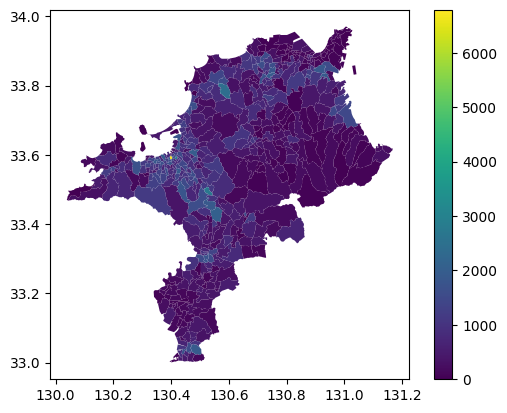

In [ ]:
geodataframe_data['Kyushu'].plot(column='dest_freq',legend=True)

<Axes: >

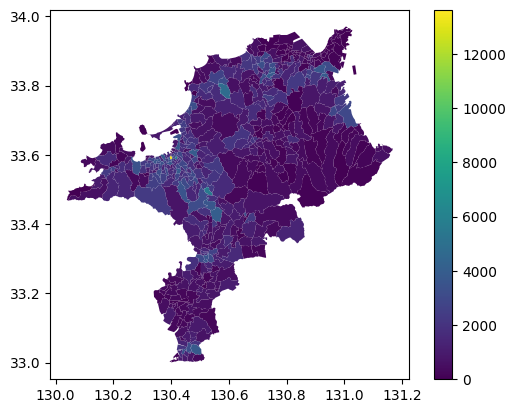

In [ ]:
geodataframe_data['Kyushu'].plot(column='freq',legend=True)

<Axes: >

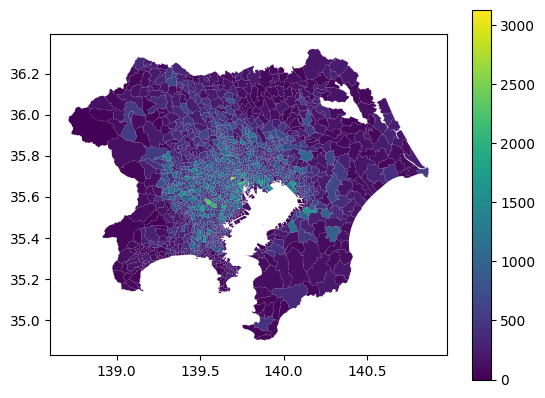

In [ ]:
geodataframe_data['Tokyo'].plot(column='origin_freq',legend=True)

<Axes: >

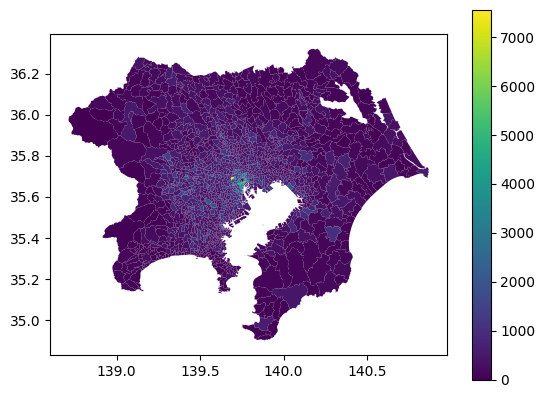

In [ ]:
geodataframe_data['Tokyo'].plot(column='dest_freq',legend=True)

<Axes: >

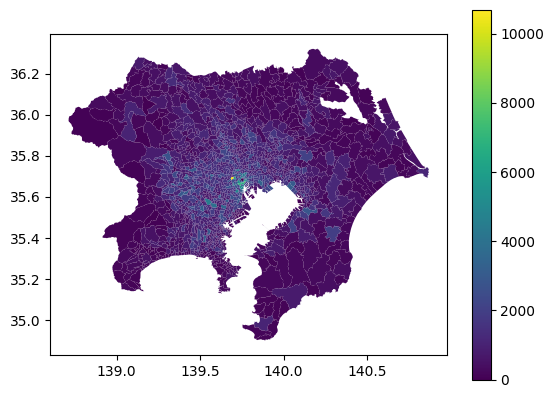

In [ ]:
geodataframe_data['Tokyo'].plot(column='freq',legend=True)

<Axes: >

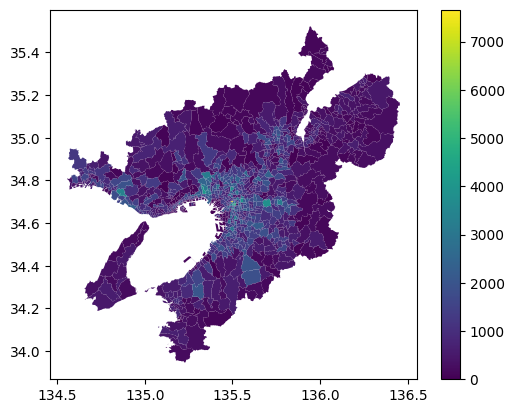

In [ ]:
geodataframe_data['Kinki'].plot(column='freq',legend=True)

<Axes: >

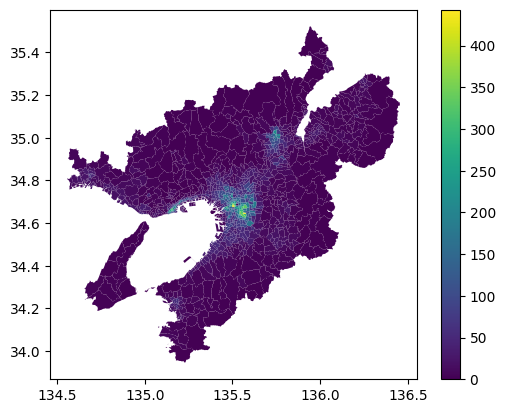

In [ ]:
geodataframe_data['Kinki'].plot(column='T000918002',legend=True)

<Axes: >

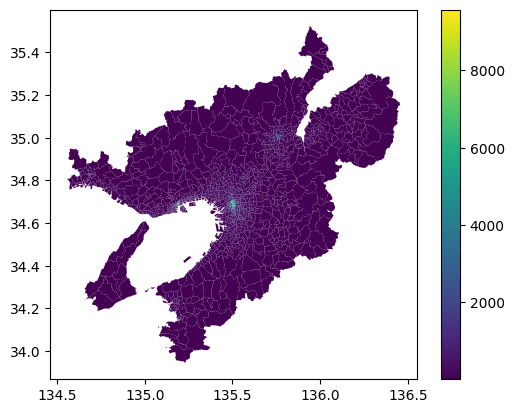

In [ ]:
geodataframe_data['Kinki'].plot(column='T000918006',legend=True)

<Axes: >

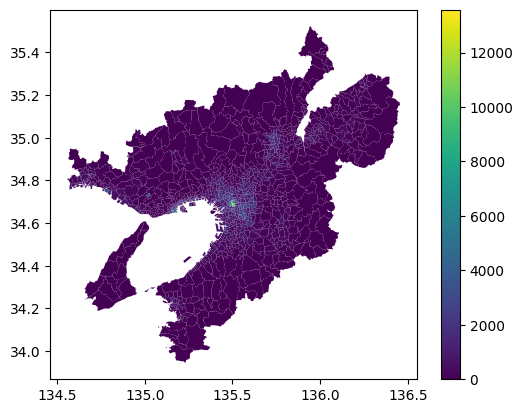

In [ ]:
geodataframe_data['Kinki'].plot(column='T000918021',legend=True)

<Axes: >

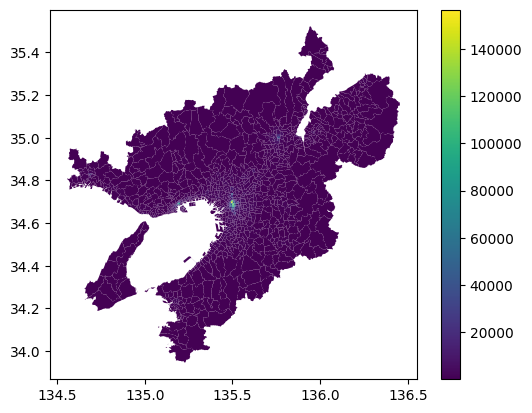

In [ ]:
geodataframe_data['Kinki'].plot(column='T000918025',legend=True)

<Axes: >

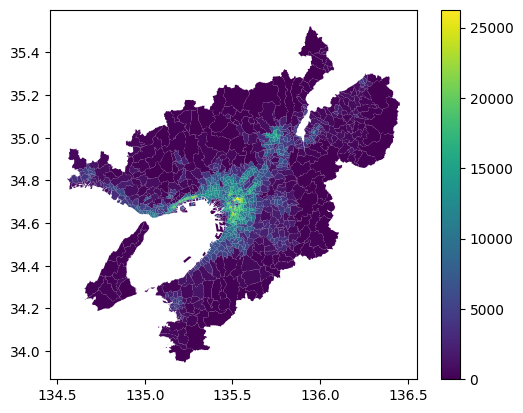

In [ ]:
geodataframe_data['Kinki'].plot(column='T000847001',legend=True)

In [ ]:
def getdistance(df, zone_name):
  zone_path = './Zones/Zones/'
  zone_pd = gpd.read_file(zone_path+zone_name+'/'+zone_name+'.shp')
  d = {}
  for i,row in zone_pd.iterrows():
    d[int(row['ZONE_ID'])] = row['geometry']
  l = []
  for i,row in df.iterrows():
    origin,dest = int(row['Origin']), int(row['Destination'])
    l.append(d[origin].distance(d[dest]))
  df['distance'] = l
  return df

In [ ]:
zone_list = ['Tokyo', 'Chukyo', 'Kyushu', 'Higashisuruga', 'Kinki']
for zone_name in zone_list[:4]:
    train_data[zone_name] = getdistance(train_data[zone_name], zone_name)


<Axes: >

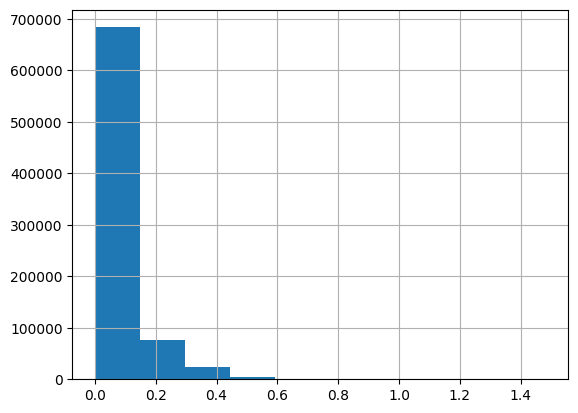

In [ ]:
train_data['Tokyo']['distance'].hist()

In [ ]:
df_all = pd.concat([train_data['Tokyo'], train_data['Chukyo'], train_data['Kyushu'],train_data['Higashisuruga']], ignore_index=True)
nrt_data = df_all[df_all['round_trip'] == 0]

<Axes: >

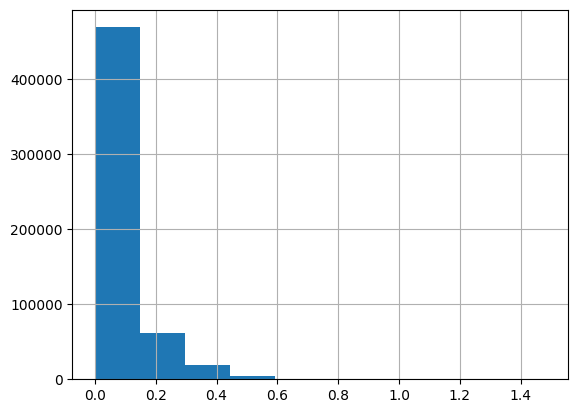

In [ ]:
nrt_data['distance'].hist()

In [ ]:
len(nrt_data[nrt_data['distance']<0.1])/len(nrt_data)

0.7786489572343224

In [ ]:
catcols = df_all.select_dtypes(['object']).columns
df_all[catcols] = df_all[catcols].astype('category')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1374291 entries, 0 to 1374290
Data columns (total 22 columns):
 #   Column                             Non-Null Count    Dtype         
---  ------                             --------------    -----         
 0   Pid                                1374291 non-null  int64         
 1   Departure_time                     1374291 non-null  datetime64[ns]
 2   Gender                             1374291 non-null  int64         
 3   Age                                1374291 non-null  int64         
 4   Occupation                         1374291 non-null  int64         
 5   Trip_type                          1374291 non-null  int64         
 6   Origin                             1374291 non-null  int64         
 7   Destination                        1374291 non-null  int64         
 8   Occupation_washed                  1374291 non-null  int64         
 9   Occupation_Categorical             1367270 non-null  category      
 10  Trip_t

In [ ]:
train_data['Tokyo'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 790613 entries, 673929 to 145761
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Pid                                790613 non-null  int64         
 1   Departure_time                     790613 non-null  datetime64[ns]
 2   Gender                             790613 non-null  int64         
 3   Age                                790613 non-null  int64         
 4   Occupation                         790613 non-null  int64         
 5   Trip_type                          790613 non-null  int64         
 6   Origin                             790613 non-null  int64         
 7   Destination                        790613 non-null  int64         
 8   Occupation_washed                  790613 non-null  int64         
 9   Occupation_Categorical             783592 non-null  category      
 10  Trip_type_washed    

# Round-Trip classification

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

features = ['Gender', 'Age', 'Occupation_washed', 'Trip_type_washed', 'Departure_time_washed', 'T000918002', 'T000918006', 'T000918021', 'T000847001']

dtree = DecisionTreeClassifier()

# df_train = df_all[~df_all.Trip_type_washed.isin([9,11])]
df_train = df_all[df_all.Trip_type_washed != 9]
x = df_train[features]
y = df_train['round_trip']
dtree.fit(x, y)
y_dp = dtree.predict(x)
accuracy_score(y_dp, y)

0.8828680950495814

In [ ]:
confusion_matrix(y_dp, y)

array([[490352,  99564],
       [ 58139, 698316]])

In [ ]:
df = train_data['Tokyo']
x = df[features]
y = df['round_trip']
y_dp = dtree.predict(x)
for i,row in x.iterrows():
  if row['Trip_type_washed']==9:
    y_dp[i] = 1

In [ ]:
accuracy_score(y_dp, y)

0.8300470647459629

In [ ]:
confusion_matrix(y_dp, y)

array([[341956,  80265],
       [ 54102, 314290]])

In [ ]:
logreg = LogisticRegression(random_state=16)
logreg.fit(x, y)
y_lp = logreg.predict(x)
accuracy_score(y_lp, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5583932973528136

In [ ]:
confusion_matrix(y_lp, y)

array([[192455, 145537],
       [203603, 249018]])

In [ ]:
df = train_data['Tokyo']
x = df[features]
y = df['round_trip']
y_lp = logreg.predict(x)
for i,row in x.iterrows():
  if row['Trip_type_washed']==9:
    y_lp[i] = 1

In [ ]:
accuracy_score(y_lp, y)

0.5140555493016179

In [ ]:
confusion_matrix(y_lp, y)

array([[ 62956,  51092],
       [333102, 343463]])